# 8장 Image captioning

### Download COCO dataset

In [ ]:
### linux
#!apt-get install wget
### mac
#!brew install wget
 
### create a data directory
#!mkdir data_dir
 
### download images and annotations to the data directory
#!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P ./data_dir/
#!wget http://images.cocodataset.org/zips/train2014.zip -P ./data_dir/
#!wget http://images.cocodataset.org/zips/val2014.zip -P ./data_dir/
    
### extract zipped images and annotations and remove the zip files
#!unzip ./data_dir/captions_train-val2014.zip -d ./data_dir/
#!rm ./data_dir/captions_train-val2014.zip
#!unzip ./data_dir/train2014.zip -d ./data_dir/
#!rm ./data_dir/train2014.zip 
#!unzip ./data_dir/val2014.zip -d ./data_dir/ 
#!rm ./data_dir/val2014.zip

In [ ]:
# Window download
import urllib.request
import zipfile
import os

# urls = ["http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
#         "http://images.cocodataset.org/zips/train2014.zip",
#         "http://images.cocodataset.org/zips/val2014.zip"]


# for url in urls:
#     filename = os.path.basename(url)
#     zip_path, _ = urllib.request.urlretrieve(url, filename=filename)
#     with zipfile.ZipFile(filename, 'r') as zip_ref:
#         name = os.path.splitext(filename)[0]
#         save_folder = "data_dir/" + name
#         zip_ref.extractall(save_folder)

url = "http://images.cocodataset.org/annotations/annotations_trainval2014.zip"
zip_path, _ = urllib.request.urlretrieve(url, filename="annotations_trainval2014.zip")

with zipfile.ZipFile("annotations_trainval2014.zip", 'r') as zip_ref:
    zip_ref.extractall("./data_dir/annotations_trainval2014")


url = "http://images.cocodataset.org/zips/train2014.zip"
zip_path, _ = urllib.request.urlretrieve(url, filename="train2014.zip")

with zipfile.ZipFile("train2014.zip", 'r') as zip_ref:
    zip_ref.extractall("./data_dir/train2014")

url = "http://images.cocodataset.org/zips/val2014.zip"
zip_path, _ = urllib.request.urlretrieve(url, filename="val2014.zip")

with zipfile.ZipFile("val2014.zip", 'r') as zip_ref:
    zip_ref.extractall("./data_dir/val2014")

## import dependencies

In [1]:
import os
import nltk
import pickle
import numpy as np
from PIL import Image
from collections import Counter
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
 
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.nn.utils.rnn import pack_padded_sequence

In [15]:
# Tokenizer download

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nbumk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nbumk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

## build vocab

In [2]:
import json
json_file = 'data_dir/annotations_trainval2014/captions_train2014.json'

with open(json_file, 'r') as f:
    data = json.load(f)

print(data.keys())
display(data['images'][0])
display(data['annotations'][0])

dict_keys(['info', 'images', 'licenses', 'annotations'])


{'license': 5,
 'file_name': 'COCO_train2014_000000057870.jpg',
 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-14 16:28:13',
 'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
 'id': 57870}

{'image_id': 318556,
 'id': 48,
 'caption': 'A very clean and well decorated empty bathroom'}

In [13]:
## debug
json = 'data_dir/annotations_trainval2014/captions_train2014.json'
coco = COCO(json)
# display(coco.anns.keys())

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


In [14]:
display(coco.anns)
# {48: {'image_id': 318556,
#   'id': 48,
#   'caption': 'A very clean and well decorated empty bathroom'},
#  67: {'image_id': 116100,
#   'id': 67,
#   'caption': 'A panoramic view of a kitchen and all of its appliances.'},
#   ...
# }
print("="*50)
coco.loadImgs(318556)

{48: {'image_id': 318556,
  'id': 48,
  'caption': 'A very clean and well decorated empty bathroom'},
 67: {'image_id': 116100,
  'id': 67,
  'caption': 'A panoramic view of a kitchen and all of its appliances.'},
 126: {'image_id': 318556,
  'id': 126,
  'caption': 'A blue and white bathroom with butterfly themed wall tiles.'},
 148: {'image_id': 116100,
  'id': 148,
  'caption': 'A panoramic photo of a kitchen and dining room'},
 173: {'image_id': 379340,
  'id': 173,
  'caption': 'A graffiti-ed stop sign across the street from a red car '},
 188: {'image_id': 379340,
  'id': 188,
  'caption': 'A vandalized stop sign and a red beetle on the road'},
 219: {'image_id': 318556,
  'id': 219,
  'caption': 'A bathroom with a border of butterflies and blue paint on the walls above it.'},
 255: {'image_id': 318556,
  'id': 255,
  'caption': 'An angled view of a beautifully decorated bathroom.'},
 272: {'image_id': 134754,
  'id': 272,
  'caption': 'The two people are walking down the beach.'

[{'license': 1,
  'file_name': 'COCO_train2014_000000318556.jpg',
  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000318556.jpg',
  'height': 640,
  'width': 480,
  'date_captured': '2013-11-15 05:00:35',
  'flickr_url': 'http://farm4.staticflickr.com/3133/3378902101_3c9fa16b84_z.jpg',
  'id': 318556}]

In [23]:
coco_keys = list(coco.anns.keys())
print(coco_keys[:10])
print(len(coco_keys))

[48, 67, 126, 148, 173, 188, 219, 255, 272, 288]
414113


In [25]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')  # Only needed once

text = "Hello, world! How's everything?"
# text = "Great observation — and you're absolutely right to point this out. Here's the correct explanation:"
# text = r"[nltk_data]   Unzipping tokenizers\punkt_tab.zip."

tokens = word_tokenize(text)
print(tokens)

['Hello', ',', 'world', '!', 'How', "'s", 'everything', '?']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nbumk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
class Vocab(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.w2i = {}
        self.i2w = {}
        self.index = 0
 
    def __call__(self, token):
        if token not in self.w2i:
            return self.w2i['<unk>']
        return self.w2i[token]
 
    def __len__(self):
        return len(self.w2i)
    
    def add_token(self, token):
        if token not in self.w2i:
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            self.index += 1

def build_vocabulary(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)
 
        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))
 
    # If the word frequency is less than 'threshold', then the word is discarded.
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]
 
    # Create a vocab wrapper and add some special tokens.
    vocab = Vocab()
    vocab.add_token('<pad>')
    vocab.add_token('<start>')
    vocab.add_token('<end>')
    vocab.add_token('<unk>')
 
    # Add the words to the vocabulary.
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab
 
vocab = build_vocabulary(json='data_dir/annotations_trainval2014/captions_train2014.json', threshold=4)

# print(type(vocab)) => # <class '__main__.Vocab'>
vocab_path = './data_dir/vocabulary.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
[1000/414113] Tokenized the captions.
[2000/414113] Tokenized the captions.
[3000/414113] Tokenized the captions.
[4000/414113] Tokenized the captions.
[5000/414113] Tokenized the captions.
[6000/414113] Tokenized the captions.
[7000/414113] Tokenized the captions.
[8000/414113] Tokenized the captions.
[9000/414113] Tokenized the captions.
[10000/414113] Tokenized the captions.
[11000/414113] Tokenized the captions.
[12000/414113] Tokenized the captions.
[13000/414113] Tokenized the captions.
[14000/414113] Tokenized the captions.
[15000/414113] Tokenized the captions.
[16000/414113] Tokenized the captions.
[17000/414113] Tokenized the captions.
[18000/414113] Tokenized the captions.
[19000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[21000/414113] Tokenized the captions.
[22000/414113] Tokenized the captions.
[23000/414113] Tokenized the captions.
[24000/414113] Tokenized the 

In [4]:
## Check vocab dictionary

display(vocab.w2i)
display(vocab.i2w)


{'<pad>': 0,
 '<start>': 1,
 '<end>': 2,
 '<unk>': 3,
 'a': 4,
 'very': 5,
 'clean': 6,
 'and': 7,
 'well': 8,
 'decorated': 9,
 'empty': 10,
 'bathroom': 11,
 'panoramic': 12,
 'view': 13,
 'of': 14,
 'kitchen': 15,
 'all': 16,
 'its': 17,
 'appliances': 18,
 '.': 19,
 'blue': 20,
 'white': 21,
 'with': 22,
 'butterfly': 23,
 'themed': 24,
 'wall': 25,
 'tiles': 26,
 'photo': 27,
 'dining': 28,
 'room': 29,
 'stop': 30,
 'sign': 31,
 'across': 32,
 'the': 33,
 'street': 34,
 'from': 35,
 'red': 36,
 'car': 37,
 'vandalized': 38,
 'beetle': 39,
 'on': 40,
 'road': 41,
 'border': 42,
 'butterflies': 43,
 'paint': 44,
 'walls': 45,
 'above': 46,
 'it': 47,
 'an': 48,
 'angled': 49,
 'beautifully': 50,
 'two': 51,
 'people': 52,
 'are': 53,
 'walking': 54,
 'down': 55,
 'beach': 56,
 'sink': 57,
 'toilet': 58,
 'inside': 59,
 'small': 60,
 'black': 61,
 'square': 62,
 'tile': 63,
 'floor': 64,
 'that': 65,
 'needs': 66,
 'repairs': 67,
 'vanity': 68,
 'contains': 69,
 'sinks': 70,
 'towel

{0: '<pad>',
 1: '<start>',
 2: '<end>',
 3: '<unk>',
 4: 'a',
 5: 'very',
 6: 'clean',
 7: 'and',
 8: 'well',
 9: 'decorated',
 10: 'empty',
 11: 'bathroom',
 12: 'panoramic',
 13: 'view',
 14: 'of',
 15: 'kitchen',
 16: 'all',
 17: 'its',
 18: 'appliances',
 19: '.',
 20: 'blue',
 21: 'white',
 22: 'with',
 23: 'butterfly',
 24: 'themed',
 25: 'wall',
 26: 'tiles',
 27: 'photo',
 28: 'dining',
 29: 'room',
 30: 'stop',
 31: 'sign',
 32: 'across',
 33: 'the',
 34: 'street',
 35: 'from',
 36: 'red',
 37: 'car',
 38: 'vandalized',
 39: 'beetle',
 40: 'on',
 41: 'road',
 42: 'border',
 43: 'butterflies',
 44: 'paint',
 45: 'walls',
 46: 'above',
 47: 'it',
 48: 'an',
 49: 'angled',
 50: 'beautifully',
 51: 'two',
 52: 'people',
 53: 'are',
 54: 'walking',
 55: 'down',
 56: 'beach',
 57: 'sink',
 58: 'toilet',
 59: 'inside',
 60: 'small',
 61: 'black',
 62: 'square',
 63: 'tile',
 64: 'floor',
 65: 'that',
 66: 'needs',
 67: 'repairs',
 68: 'vanity',
 69: 'contains',
 70: 'sinks',
 71: 't

## resize images

In [ ]:
def reshape_image(image, shape):
    """Resize an image to the given shape."""
    return image.resize(shape, Image.Resampling.BILINEAR)
 
def reshape_images(image_path, output_path, shape):
    """Reshape the images in 'image_path' and save into 'output_path'."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)
 
    images = os.listdir(image_path)
    num_im = len(images)
    for i, im in enumerate(images):
        with open(os.path.join(image_path, im), 'r+b') as f:
            with Image.open(f) as image:
                image = reshape_image(image, shape)
                image.save(os.path.join(output_path, im), image.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_im, output_path))

image_path = './data_dir/train2014/'
output_path = './data_dir/resized_images/'
image_shape = [256, 256]
reshape_images(image_path, output_path, image_shape)

## instantiate data loader

In [36]:
## data_batch
# def __getitem__(self, idx):
#     image = load_image(idx)           # Tensor
#     caption = get_caption(idx)        # String
#     return image, caption


# # Then if your batch_size=4, data_batch will be:
# [
#   (image1, caption1),
#   (image2, caption2),
#   (image3, caption3),
#   (image4, caption4)
# ]


data = [
  ("image1", "caption1"),
  ("image2", "caption2"),
  ("image3", "caption3"),
  ("image4", "caption4")
]

zip_data = zip(*data)
# imgs, caps = zip_data # ## data_batch
# def __getitem__(self, idx):
#     image = load_image(idx)           # Tensor
#     caption = get_caption(idx)        # String
#     return image, caption


# # Then if your batch_size=4, data_batch will be:
# [
#   (image1, caption1),
#   (image2, caption2),
#   (image3, caption3),
#   (image4, caption4)
# ]


data = [
  ("image1", "caption1"),
  ("image2", "caption2"),
  ("image3", "caption3"),
  ("image4", "caption4")
]

imgs, caps = zip(*data)
print(imgs)
print(caps)

('image1', 'image2', 'image3', 'image4')
('caption1', 'caption2', 'caption3', 'caption4')


In [5]:
class CustomCocoDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, imgs_path, coco_json_path, vocabulary, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = imgs_path
        self.coco_data = COCO(coco_json_path)
        self.indices = list(self.coco_data.anns.keys()) # [48, ]
        self.vocabulary = vocabulary
        self.transform = transform
 
    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        coco_data = self.coco_data
        vocabulary = self.vocabulary
        annotation_id = self.indices[idx]
        caption = coco_data.anns[annotation_id]['caption']
        image_id = coco_data.anns[annotation_id]['image_id']
        image_path = coco_data.loadImgs(image_id)[0]['file_name']
 
        image = Image.open(os.path.join(self.root, image_path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
 
        # Convert caption (string) to word ids.
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocabulary('<start>'))
        caption.extend([vocabulary(token) for token in word_tokens])
        caption.append(vocabulary('<end>'))
        ground_truth = torch.Tensor(caption)
        return image, ground_truth
 
    def __len__(self):
        return len(self.indices)
 
# customize how a list of samples from the dataset is combined into a single batch.
# data_batch: A list of individual data samples returned by your dataset's __getitem__ method

def collate_function(data_batch):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption).
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """

    # Sort a data list by caption length (descending order).
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    imgs, caps = zip(*data_batch)
 
    # Merge images (from list of 3D tensors to 4D tensor).
    # Originally, imgs is a list of <batch_size> number of RGB images with dimensions (3, 256, 256)
    # This line of code turns it into a single tensor of dimensions (<batch_size>, 3, 256, 256)
    imgs = torch.stack(imgs, 0)
 
    # Merge captions (from list of 1D tensors to 2D tensor), similar to merging of images done above.
    cap_lens = [len(cap) for cap in caps]
    tgts = torch.zeros(len(caps), max(cap_lens)).long()
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        tgts[i, :end] = cap[:end]        
    return imgs, tgts, cap_lens
 
def get_loader(imgs_path, coco_json_path, vocabulary, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco_dataser = CustomCocoDataset(imgs_path=imgs_path,
                                     coco_json_path=coco_json_path,
                                     vocabulary=vocabulary,
                                     transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    custom_data_loader = DataLoader(dataset=coco_dataser, 
                                    batch_size=batch_size,
                                    shuffle=shuffle,
                                    num_workers=num_workers,
                                    collate_fn=collate_function)
    return custom_data_loader


# custom_data_loader = get_loader('data_dir/train2014', 
#                                   'data_dir/annotations_trainval2014/captions_train2014.json', 
#                                   vocabulary, 
#                                   transform, 128,
#                                   shuffle=True, num_workers=0) 


In [45]:
# Check datasets
# Build data loader
custom_data_loader = get_loader('data_dir/train2014', 
                                'data_dir/annotations_trainval2014/captions_train2014.json', 
                                vocabulary, 
                                transform, 
                                128,
                                shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


In [ ]:
imgs, caps, lens = next(iter(custom_data_loader))
print("imgs.shape = ", imgs.shape) 
print(caps[:5])
print("lens = ", lens[:5])

## model definition

In [58]:
weights = models.ResNet152_Weights.IMAGENET1K_V1
resnet = models.resnet152(weights = weights)
list(resnet.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [6]:
import torch
import torch.nn as nn

torch.manual_seed(0)

# Suppose the input has 6 features per sample
bn = nn.BatchNorm1d(num_features=6)

x = torch.randn(3, 6)  # batch of 32 samples, each with 10 features
out = bn(x)

print("x = \n", x)
print("out = \n", out)


x = 
 tensor([[-1.1258, -1.1524,  0.5667,  0.7935,  0.5988, -1.5551],
        [-0.3414,  1.8530,  0.4681, -0.1577, -0.1734,  0.1835],
        [ 1.3894,  1.5863,  0.9463, -0.8437,  0.9318,  1.2590]])
out = 
 tensor([[-1.0467, -1.4097, -0.4544,  1.2853,  0.3163, -1.3089],
        [-0.3002,  0.8030, -0.9324, -0.1317, -1.3518,  0.1906],
        [ 1.3469,  0.6067,  1.3869, -1.1536,  1.0356,  1.1183]],
       grad_fn=<NativeBatchNormBackward0>)


In [59]:
feature = [-1.1258, -0.3414, 1.3894]
mean = np.mean(feature)
std = np.std(feature)
(feature - mean)/std

array([-1.0467179 , -0.3002224 ,  1.34694029])

In [58]:
import torch
import torch.nn as nn

flatten = nn.Flatten()

x = torch.randn(32, 3, 28, 28)  # e.g., batch of 32 RGB images
out = flatten(x)  # shape: [32, 3*28*28] = [32, 2352]

print(out.shape)
# Output: torch.Size([32, 2352])

torch.Size([32, 2352])


In [ ]:
# Given:
# embeddings: shape (10, 10, 256)
# input_features: shape (10, 256)

# torch.cat([(10, 1, 256), (10, 10, 256)], dim=1) → shape: (10, 11, 256)

In [ ]:
# encoder_model = CNNModel(256).to(device)
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(CNNModel, self).__init__()
        weights = models.ResNet152_Weights.IMAGENET1K_V1
        resnet = models.resnet152(weights = weights)
        module_list = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_module = nn.Sequential(*module_list)
        for param in self.resnet_module.parameters():
            param.requires_grad = False
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        self.flatten = nn.Flatten()
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)
   
    def forward(self, input_images):
        """Extract feature vectors from input images."""
        # with torch.no_grad():
        #     resnet_features = self.resnet_module(input_images)

        resnet_features = self.resnet_module(input_images)
        resnet_features =  self.flatten(resnet_features)
        # resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        
        resnet_features =  self.linear_layer(resnet_features)
        final_features = self.batch_norm(resnet_features)
        return final_features # batch size x 256
 
#  decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)
#  decoder_model(feats, caps, lens), feats = (batch size, 256), caps = (batch size, 256)
class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        """Set the hyper-parameters and build the layers."""
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len
        
    def forward(self, input_features, capts, lens):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embedding_layer(capts)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True, enforce_sorted=True)
        # why not lens + 1 ??
        hidden_variables, _ = self.lstm_layer(lstm_input)
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs
    
    def sample(self, input_features, lstm_states=None):
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)          # hiddens: (batch_size, 1, hidden_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted_outputs = model_outputs.max(1)                        # predicted: (batch_size)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)                       # inputs: (batch_size, embed_size)
            lstm_inputs = lstm_inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_indices = torch.stack(sampled_indices, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_indices
    

# Generate an caption from the image
# feat = encoder_model(img_tensor)
# sampled_indices = decoder_model.sample(feat)
# sampled_indices = sampled_indices[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

## training loop

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create model directory
if not os.path.exists('models_dir/'):
    os.makedirs('models_dir/')

    
# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

    
# Build data loader
custom_data_loader = get_loader('data_dir/train2014', 
                                'data_dir/annotations_trainval2014/captions_train2014.json', 
                                vocabulary, 
                                transform, 128,
                                shuffle=True, num_workers=0) 


# Build the models
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)
 
    
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
parameters = list(encoder_model.parameters()) + list(decoder_model.parameters())
optimizer = optim.Adam(parameters, lr=0.001)


# Train the models
total_num_steps = len(custom_data_loader)
for epoch in range(2):
    for i, (imgs, caps, lens) in enumerate(custom_data_loader):
 
        # Set mini-batch dataset
        imgs = imgs.to(device)
        caps = caps.to(device) # zero padded seq e.g., batch_size x padded sequences
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]
 
        # Forward, backward and optimize
        feats = encoder_model(imgs) # => batch size x 256
        outputs = decoder_model(feats, caps, lens)
        loss = criterion(outputs, tgts)
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()
 
        # Print log info
        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 5, i, total_num_steps, loss.item(),
                          np.exp(loss.item()))) 
 
        # Save the model checkpoints
        if (i+1) % 1000 == 0:
            torch.save(decoder_model.state_dict(), os.path.join(
                'models_dir/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder_model.state_dict(), os.path.join(
                'models_dir/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
Epoch [0/5], Step [0/3236], Loss: 9.2188, Perplexity: 10085.0087
Epoch [0/5], Step [10/3236], Loss: 5.7634, Perplexity: 318.4208
Epoch [0/5], Step [20/3236], Loss: 5.3208, Perplexity: 204.5442
Epoch [0/5], Step [30/3236], Loss: 4.8187, Perplexity: 123.7991
Epoch [0/5], Step [40/3236], Loss: 4.5270, Perplexity: 92.4837
Epoch [0/5], Step [50/3236], Loss: 4.3571, Perplexity: 78.0343
Epoch [0/5], Step [60/3236], Loss: 4.0927, Perplexity: 59.9009
Epoch [0/5], Step [70/3236], Loss: 3.8950, Perplexity: 49.1584
Epoch [0/5], Step [80/3236], Loss: 3.9102, Perplexity: 49.9066
Epoch [0/5], Step [90/3236], Loss: 3.8891, Perplexity: 48.8668
Epoch [0/5], Step [100/3236], Loss: 3.7970, Perplexity: 44.5666
Epoch [0/5], Step [110/3236], Loss: 3.6644, Perplexity: 39.0309
Epoch [0/5], Step [120/3236], Loss: 3.8284, Perplexity: 45.9888
Epoch [0/5], Step [130/3236], Loss: 3.5255, Perplexity: 33.9717
Epoch [0/5], Step [140/323

## Predict caption

a baseball player swings at a ball while the catcher is ready to catch the ball .


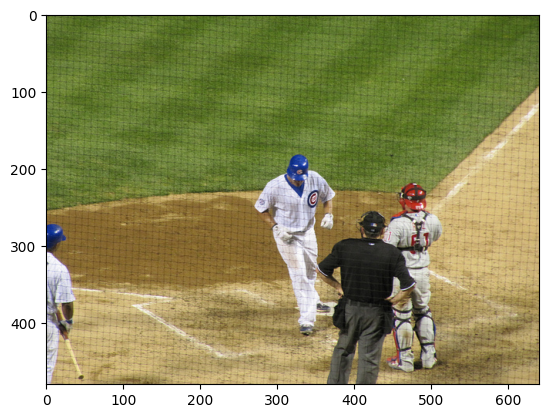

In [ ]:
import re

image_file_path = './figure_sample/sample_3.jpg'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize([224, 224], Image.Resampling.BILINEAR)
    
    if transform is not None:
        img = transform(img).unsqueeze(0)
    
    return img
 

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build models
encoder_model = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# Load the trained model parameters
encoder_model.load_state_dict(torch.load('models_dir_2epoch/encoder-2-3000.ckpt'))
decoder_model.load_state_dict(torch.load('models_dir_2epoch/decoder-2-3000.ckpt'))


# Prepare an image
img = load_image(image_file_path, transform)
img_tensor = img.to(device)


# Generate an caption from the image
feat = encoder_model(img_tensor)
sampled_indices = decoder_model.sample(feat)
sampled_indices = sampled_indices[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)


# Convert word_ids to words
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_sentence = ' '.join(predicted_caption)
matched = re.search(r"<start>\s*(.*?)\s*<end>", predicted_sentence)
sentence = matched.group(1)

# Print out the image and the generated caption
%matplotlib inline
print (sentence)
img = Image.open(image_file_path)
# plt.imshow(np.asarray(img))
plt.imshow(img)


In [11]:
import re
predicted_sentence = "<start> a baseball player swings at a ball while the catcher is ready to catch the ball . <end>"
matched = re.search(r"<start>\s*(.*?)\s*<end>", predicted_sentence)

matched.group(1)

'a baseball player swings at a ball while the catcher is ready to catch the ball .'